# [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration)

## コンペについて
このコンテストでは、Kaggleはニューヨーク市でのタクシー旅行の合計乗車時間を予測するモデルを作成するように挑戦しています。プライマリデータセットは、ニューヨークタクシーアンドリムジンコミッションによってリリースされたもので、ピックアップ時間、地理座標、乗客数、およびその他のいくつかの変数が含まれています。

## データについて
- 説明変数
  - id-各旅行の一意の識別子
  - vendor_id-旅行レコードに関連付けられたプロバイダーを示すコード
  - Pickup_datetime-メーターが使用された日時
  - dropoff_datetime-メーターが外された日時
  - passenger_count-車両の乗客数（ドライバーが入力した値）
  - Pickup_longitude-メーターが使用された経度
  - Pickup_latitude-メーターが使用された緯度
  - dropoff_longitude-メーターが外された経度
  - dropoff_latitude-メーターが外れた緯度
  - store_and_fwd_flag-このフラグは、車両にサーバーへの接続がなかったため、ベンダーに送信する前にトリップレコードが車両のメモリに保持されたかどうかを示します-Y =保存して転送。N =保存も転送もなし。
- 目的変数
  - trip_duration-秒単位の旅行の所要時間
  
## 評価について
実際の所要時間と予測した所要時間の対数平方平均二乗誤差。

データの提出形式は以下の通り。
```
id、trip_duration 
id00001,978 
id00002,978 
id00003,978 
id00004,978 
:
```

## 参照したノートブック
### [Yellow Cabs tell The Story of New York City](https://www.kaggle.com/selfishgene/yellow-cabs-tell-the-story-of-new-york-city)

このスクリプトでは、タクシーの使用状況を調べることで推測できる、ニューヨークの人々の空間的および時間的な行動を探ります。\
このデータセットの主なフィールドは、タクシーの乗車時刻と場所、および降車場所と旅行時間です。\
2016年の前半に発生したデータセットには、合計で約140万回のトリップがあります。\
キャブの使用パターンが1年、1週間、1日を通してどのように変化するかを確認し、平日と週末の違いに注目します。

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

##### データを読み込み、明らかな外れ値を削除し、すべてを適切な単位に変換します

In [2]:
dataDir = ''
taxiDB = pd.read_csv(dataDir + 'train.csv')

# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.4), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32 # 緯度1度あたりの距離(km)
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32 # 経度1度あたりの距離(km)

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

In [3]:
taxiDB

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,duration [min],src lat [km],src long [km],dst lat [km],dst long [km]
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.583333,1.486707,-0.099721,1.226820,1.378075
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,11.050000,-1.783114,0.046965,-2.608213,-1.560788
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,35.400000,1.041672,0.164056,-4.953142,-2.054245
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,7.150000,-3.852868,-2.451197,-5.328110,-2.639058
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,7.250000,4.300027,0.667806,3.110152,0.678744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420053,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,12.966667,-1.008549,-0.103581,-1.604336,-1.175417
1420054,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,10.916667,-0.801743,-1.684313,4.671598,0.909709
1420055,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,12.733333,1.582678,1.841936,-5.255494,-1.978328
1420056,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,6.216667,-0.614472,-0.093287,0.281120,0.534631


##### 移動時間、緯度、経度の結果のヒストグラムをプロットします

Text(0.5, 0, 'longitude [km]')

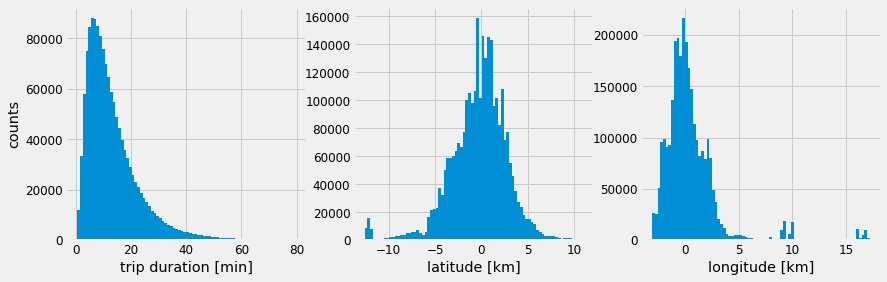

In [4]:
# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(taxiDB['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')

##### 移動時間とピックアップとドロップオフの間の空中距離をプロットします

Text(0.5, 1.0, 'log of trip Duration vs Aerial trip Distance')

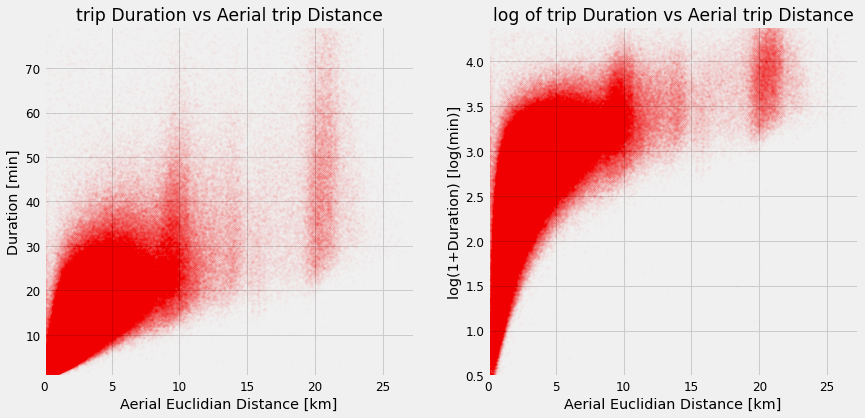

In [5]:
#%% plot scatter of trip duration vs. aerial distance between pickup and dropoff
taxiDB['log duration']       = np.log1p(taxiDB['duration [min]'])
taxiDB['euclidian distance'] = np.sqrt((taxiDB['src lat [km]']  - taxiDB['dst lat [km]'] )**2 + 
                                       (taxiDB['src long [km]'] - taxiDB['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(taxiDB['euclidian distance'], taxiDB['duration [min]'],c='r',s=5,alpha=0.01); 
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[0].set_ylim(taxiDB['duration [min]'].min(),taxiDB['duration [min]'].max())
axArray[0].set_title('trip Duration vs Aerial trip Distance')

axArray[1].scatter(taxiDB['euclidian distance'], taxiDB['log duration'],c='r',s=5,alpha=0.01); 
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[1].set_ylim(taxiDB['log duration'].min(),taxiDB['log duration'].max())
axArray[1].set_title('log of trip Duration vs Aerial trip Distance')

トリップ距離がトリップ期間の下限を定義していることがわかります。

##### ピックアップとドロップオフの位置の空間密度プロットをプロットする

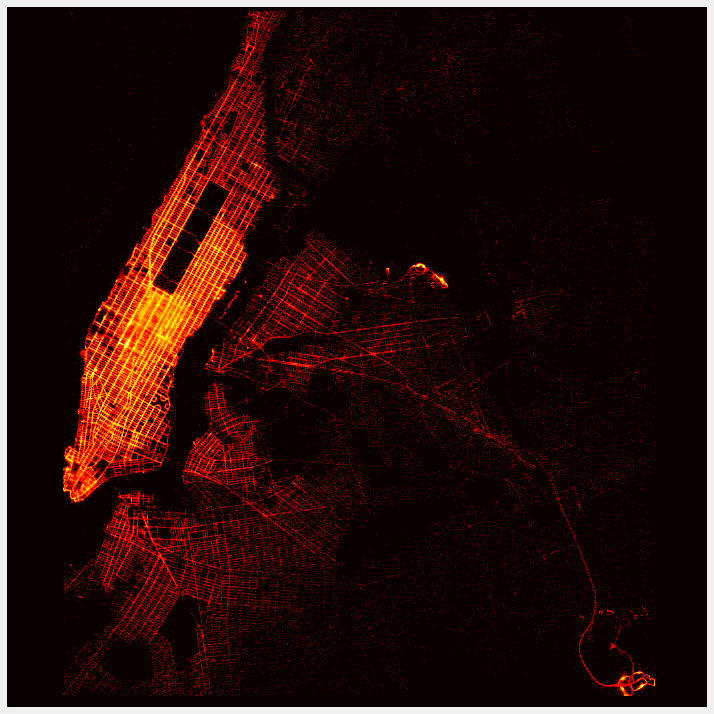

In [6]:
# show the log density of pickup and dropoff locations
imageSize = (700,700)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='hot')
ax.set_axis_off()

いいね！マンハッタンと2つの空港が「空を照らしている」ので、宇宙から見ると予想されるものの少し見えます。

### 補足
ニューヨークの地図を知らないのでGoogleマップで検索。
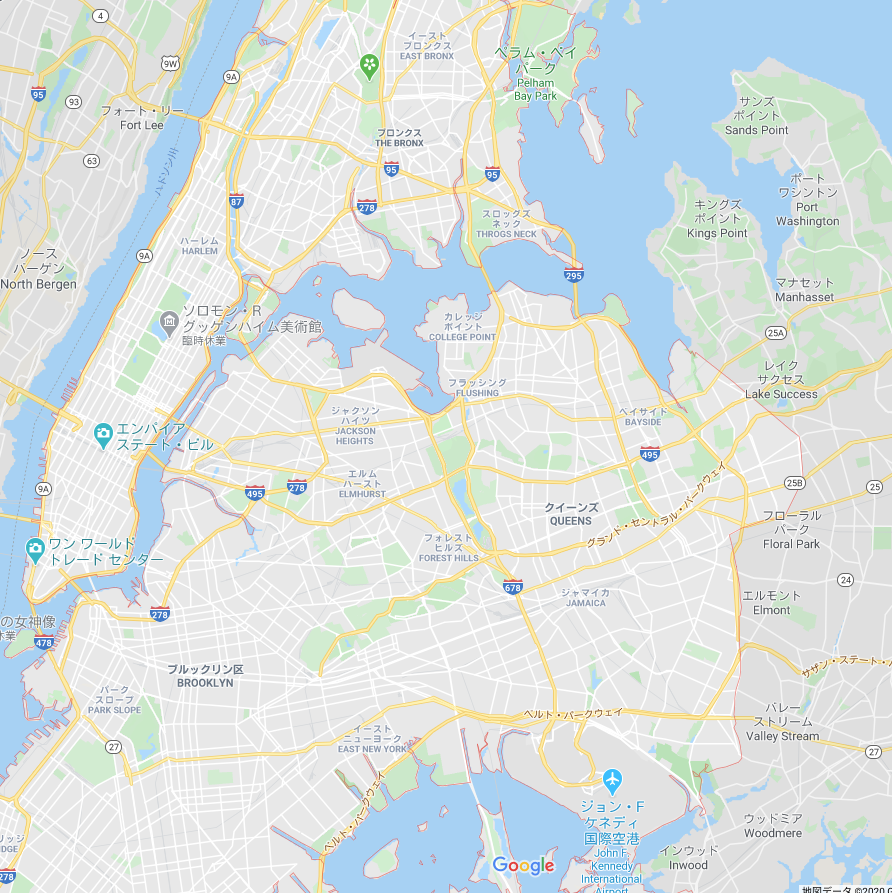

##### マンハッタンにズーム・イン！m9

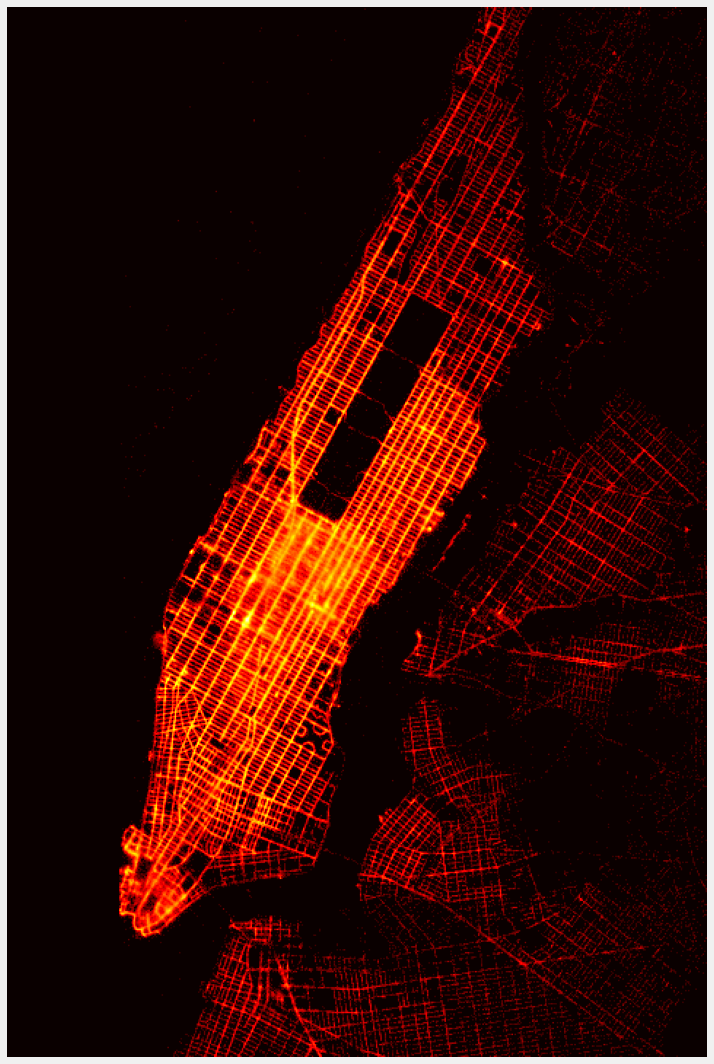

In [7]:
# zoom in on Manhattan 
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='hot')
ax.set_axis_off()

##### 後で使用できるようにいくつかの有用なフィールドを作成する

In [8]:
#%% create some new usefull fields
pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

In [9]:
taxiDB

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log duration,euclidian distance,src hourOfDay,dst hourOfDay,dayOfWeek,hourOfWeek,monthOfYear,dayOfYear,weekOfYear,hourOfYear
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2.149822,1.500473,17.400000,17.526389,0,17.400000,3,74,11,1793.400000
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2.489065,1.807114,0.716667,0.900833,6,144.716667,6,164,23,3936.716667
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,3.594569,6.392077,11.583333,12.173333,1,35.583333,1,19,3,467.583333
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2.098018,1.487155,19.533333,19.652500,2,67.533333,4,97,14,2347.533333
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2.110213,1.189925,13.500000,13.620833,5,133.500000,3,86,12,2077.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420053,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2.636674,1.226293,13.516667,13.732778,4,109.516667,4,99,14,2389.516667
1420054,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2.477938,6.056931,7.583333,7.765278,6,151.583333,1,10,1,247.583333
1420055,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2.619826,7.832945,6.950000,7.162222,4,102.950000,4,113,16,2718.950000
1420056,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,1.976393,1.093785,15.933333,16.036944,1,39.933333,1,5,1,135.933333


##### 旅行をクラスター化して分布を確認する

すべての旅行は、基本的に5つの主要な属性で構成されています：乗車場所と降車場所、および旅行期間。 140万回の旅行すべてを80の定型的なテンプレート旅行にクラスタリングしてから、この「旅行のバッグ」の分布とそれが時間とともにどのように変化するかを見てみましょう

(0.0, 81.0)

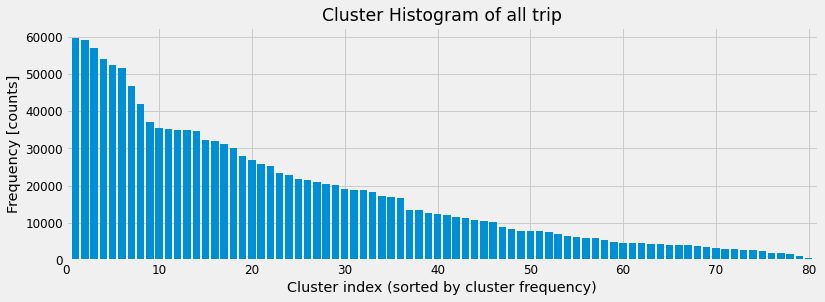

In [10]:
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

##### 地図に典型的な旅行を表示する

マゼンタの円はソース、緑の円はデスティネーション、それらの間の矢印はシアンで描かれています

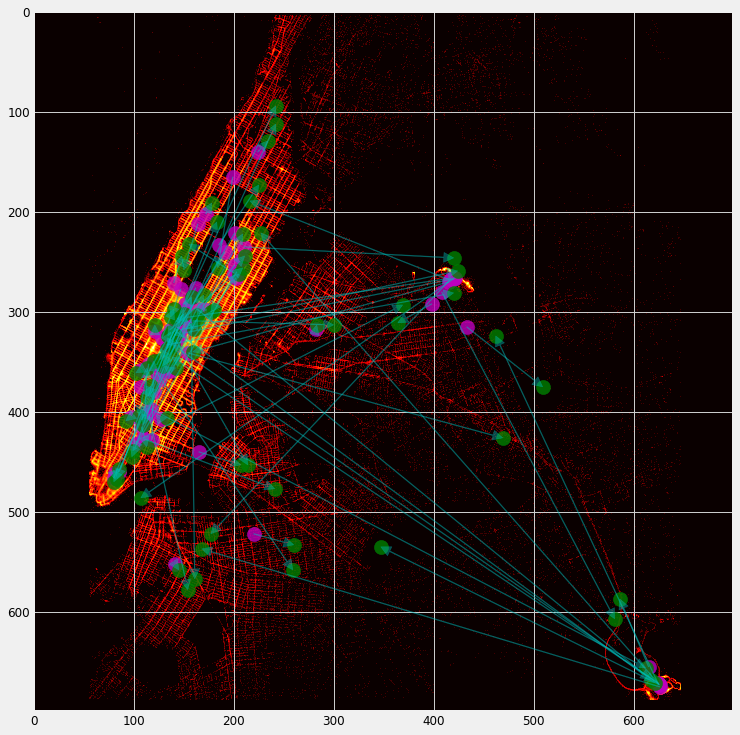

In [11]:
#%% show the templeate trips on the map
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length_includes_head=True)

マゼンタの円はソース（ピックアップの場所）、緑の円は宛先（ドロップオフの場所）で、それらの間の矢印はシアンで描かれています。 マンハッタンの周辺が主に目的地として機能し、ソースと目的地の不均一な分布を見ることができます。 （ブルックリンとクイーンズを「周辺」と呼ぶために私を殺したいと思う人もいると思います...）

###### 次に、これらの旅行の時間的側面を調べてみましょう。

##### 1日のさまざまな時間のWeekDay Trip分布

この「旅行のバッグ」は、通常の勤務時間中にどのように変化しますか？

Text(58, 1.75, 'Silent Nights')

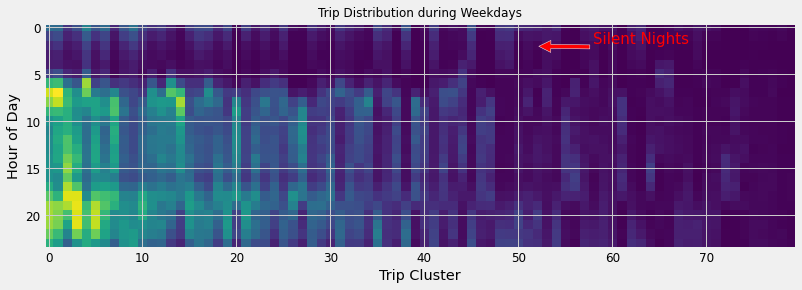

In [12]:
# calculate the trip distribution for different hours of the weekday
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Silent Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

各行には、「トリップのバッグ」分布が含まれ、強度はトリップ頻度を表します。

午前6時頃に人々が目を覚まし始め、（おそらく）仕事に向かいます。 18：00/19：00（午後6時/午後7時）頃に2回目のタクシーの急増があり、（おそらく）人々が家に帰ります。 それはまた、真夜中に、人々が夜の間ほとんど活動的でないことも非常に明白です。 これは赤い矢印でマークされています。

##### 1日の異なる時間帯の週末旅行の分布

この「旅行のバッグ」は週末にどのように変わりますか？

Text(58, 9.75, 'Late Mornings')

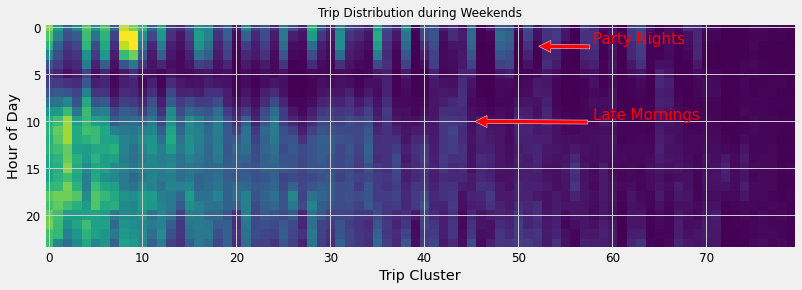

In [13]:
# calculate the trip distribution for different hours of the weekend
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Party Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Late Mornings', color='r', fontsize=15, xy=(45, 10), xytext=(58, 9.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

週末の間は、人々は夜間ははるかに活動的であり、通常の平日と比較すると、1日のかなり遅い時間に1日を開始していることがわかります。 赤い矢印は、グラフ上のこれら2つの時点を示します。

##### 異なる曜日の毎週の旅行分布

この「旅行のバッグ」は、1週間でどのように変化しますか？

Text(0, 0.5, 'Day of Week')

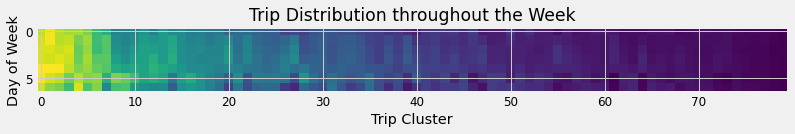

In [14]:
# calculate the trip distribution for day of week
daysOfWeek = np.sort(taxiDB['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = taxiDB['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')

ここでは、前の2つのプロットから見たものを反映しています。 週末の旅行分布のパターンは、平日とは多少異なります。

##### 年間の異なる日の年間旅行分布

この「旅行のバッグ」は、年間どのように変化しますか？

Text(50, 157, 'Memorial Day')

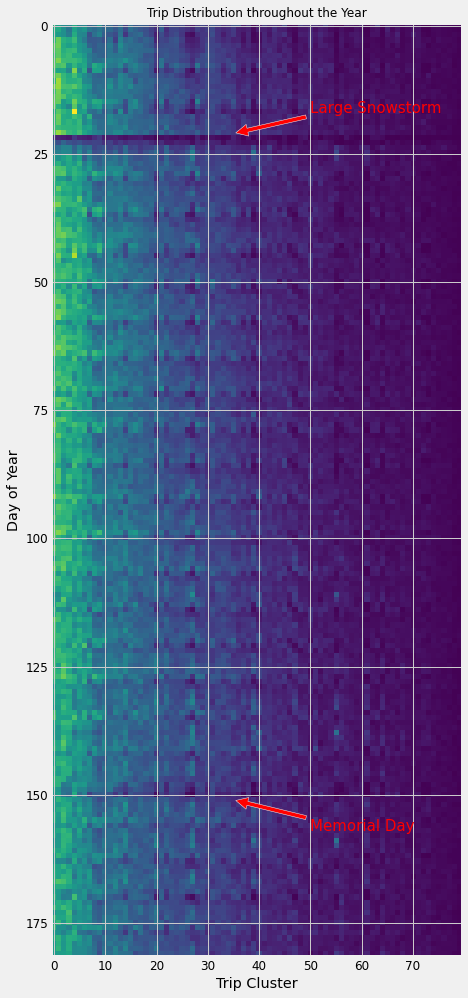

In [15]:
# calculate the trip distribution for day of year
daysOfYear = taxiDB['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear),numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = taxiDB['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,16))
ax.set_title('Trip Distribution throughout the Year', fontsize=12)
ax.imshow(clusterDistributionDayOfYear); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Day of Year')
ax.annotate('Large Snowstorm', color='r', fontsize=15 ,xy=(35, 21), xytext=(50, 17),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Memorial Day', color='r', fontsize=15, xy=(35, 151), xytext=(50, 157),
            arrowprops=dict(facecolor='red', shrink=0.03))

ここで最も明白なパターンは周期性です。 また、データには2つの大きなアクティビティの低下が見られます。1つは20〜25日目（1月末）で、もう1つは145〜150日目（5月末）です。 1月の終わりにニューヨークで大雪が降り、5月の終わりにアメリカでメモリアルデーがあることがわかりました。 これらは赤い矢印でマークされています。

##### 次に、時間的側面を詳しく見てみましょう

PCAを適用して、次元を80次元の分布ベクトルから、3次元など、より簡単にプロットして視覚化できるより扱いやすいものに減らしましょう。

In [16]:
#%% let's apply PCA to reduce the dimentionality from 80 dimentional distribution vector 
# to something more managble such as 3 dimentions

hoursOfYear = np.sort(taxiDB['hourOfYear'].astype(int).unique())
clusterDistributionHourOfYear = np.zeros((len(range(hoursOfYear[0],hoursOfYear[-1])),numClusters))
dayOfYearVec  = np.zeros(clusterDistributionHourOfYear.shape[0])
weekdayVec    = np.zeros(clusterDistributionHourOfYear.shape[0])
weekOfYearVec = np.zeros(clusterDistributionHourOfYear.shape[0])
for k, hour in enumerate(hoursOfYear):
    slectedInds = taxiDB['hourOfYear'].astype(int) == hour
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfYear[k,:] = currDistribution[sortedClusterInds]
    
    dayOfYearVec[k]  = taxiDB[slectedInds]['dayOfYear'].mean()
    weekdayVec[k]    = taxiDB[slectedInds]['dayOfWeek'].mean()
    weekOfYearVec[k] = taxiDB[slectedInds]['weekOfYear'].mean()

numComponents = 3
TripDistributionPCAModel = decomposition.PCA(n_components=numComponents,whiten=True, random_state=1)
compactClusterDistributionHourOfYear = TripDistributionPCAModel.fit_transform(clusterDistributionHourOfYear)

##### 毎週の周期性

ここでは、1週間の3つの主成分係数の時間的変化を示します

(-0.9, 167.9)

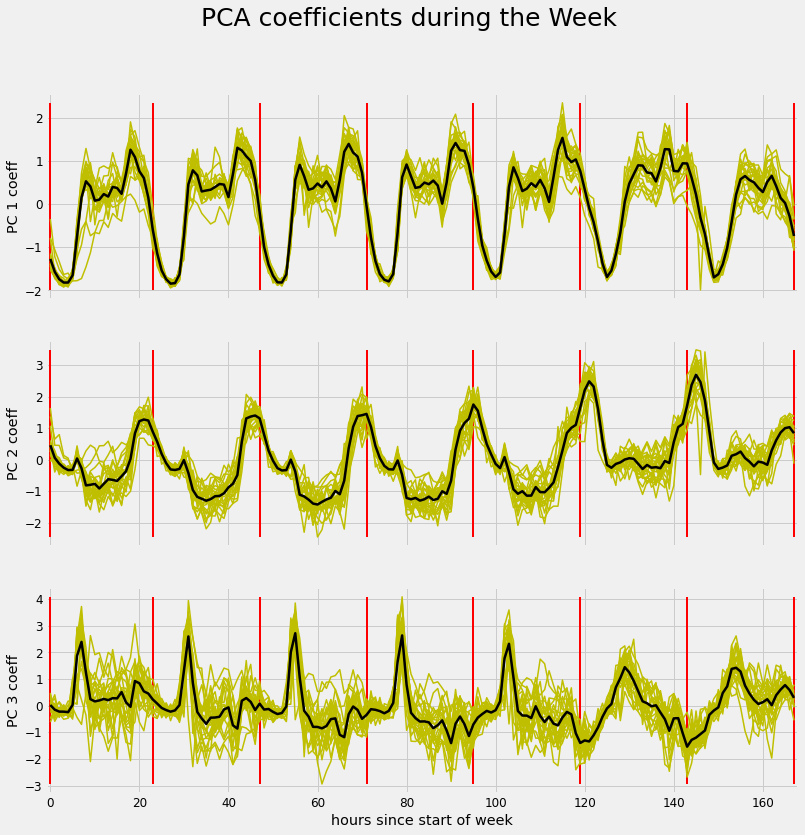

In [17]:
# collect traces for all weeks of year
listOfFullWeeks = []
for uniqueVal in np.unique(weekOfYearVec):
    if (weekOfYearVec == uniqueVal).sum() == 24*7:
        listOfFullWeeks.append(uniqueVal)

weeklyTraces = np.zeros((24*7,numComponents,len(listOfFullWeeks)))
for k, weekInd in enumerate(listOfFullWeeks):
    weeklyTraces[:,:,k] = compactClusterDistributionHourOfYear[weekOfYearVec == weekInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,12))
fig.suptitle('PCA coefficients during the Week', fontsize=25)
for PC_coeff in range(numComponents):
    meanTrace = weeklyTraces[:,PC_coeff,:].mean(axis=1)
    axArray[PC_coeff].plot(weeklyTraces[:,PC_coeff,:],'y',linewidth=1.5)
    axArray[PC_coeff].plot(meanTrace,'k',linewidth=2.5)
    axArray[PC_coeff].set_ylabel('PC %d coeff' %(PC_coeff+1))
    axArray[PC_coeff].vlines([0,23,47,71,95,119,143,167], weeklyTraces[:,PC_coeff,:].min(), weeklyTraces[:,PC_coeff,:].max(), colors='r', lw=2)
    
axArray[PC_coeff].set_xlabel('hours since start of week')
axArray[PC_coeff].set_xlim(-0.9,24*7-0.1)

黄色は、すべての週のデータを重ね合わせたものです。 黒字は平均的なトレースです。

ここでは、周期性と、通常の平日と週末の違いを明確に見ることができます。

##### 毎日の周期性

ここでは、日中の3つの主成分係数の時間的進化を示します

Text(1, 3.5, 'Late Mornings')

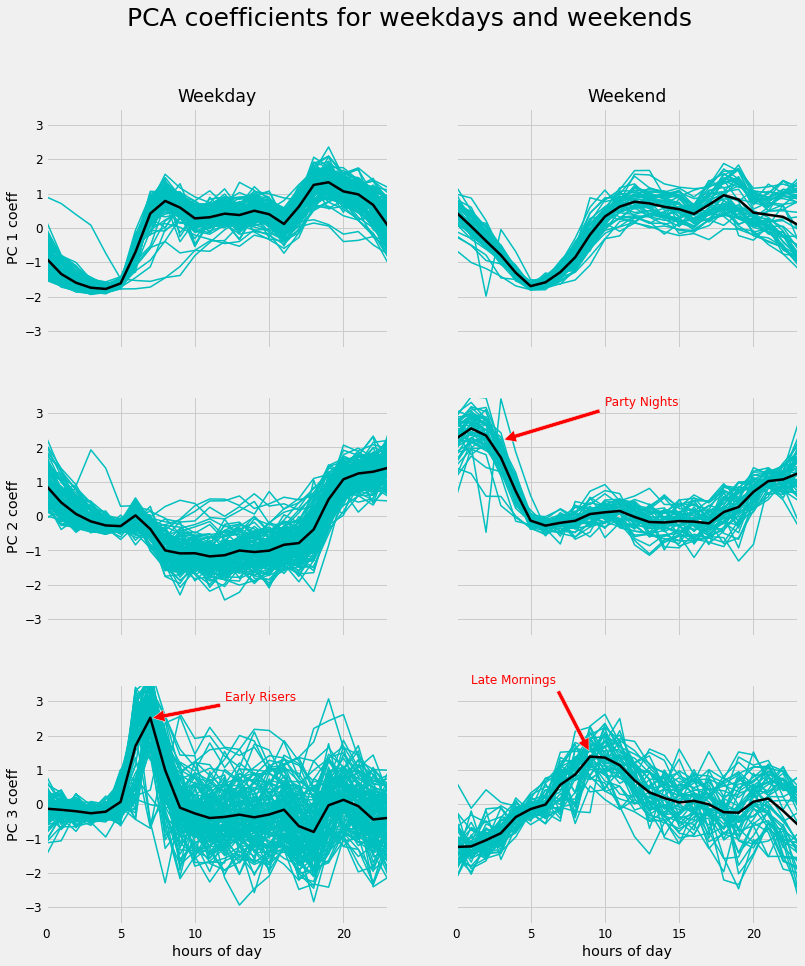

In [18]:
# collect traces for weekdays and weekends 
listOfFullWeekdays = []
listOfFullWeekends = []
for uniqueVal in np.unique(dayOfYearVec):
    if (dayOfYearVec == uniqueVal).sum() == 24:
        if weekdayVec[dayOfYearVec == uniqueVal][0] <= 4:
            listOfFullWeekdays.append(uniqueVal)
        else:
            listOfFullWeekends.append(uniqueVal)

weekdayTraces = np.zeros((24,numComponents,len(listOfFullWeekdays)))
for k, dayInd in enumerate(listOfFullWeekdays):
    weekdayTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

weekendTraces = np.zeros((24,numComponents,len(listOfFullWeekends)))
for k, dayInd in enumerate(listOfFullWeekends):
    weekendTraces[:,:,k] = compactClusterDistributionHourOfYear[dayOfYearVec == dayInd,:]

fig, axArray = plt.subplots(nrows=numComponents,ncols=2,sharex=True,sharey=True, figsize=(12,14))
fig.suptitle('PCA coefficients for weekdays and weekends', fontsize=25)
for PC_coeff in range(numComponents):
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][0].plot(weekdayTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    axArray[PC_coeff][0].set_ylabel('PC %d coeff' %(PC_coeff+1))
    
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:],'c',linewidth=1.5)
    axArray[PC_coeff][1].plot(weekendTraces[:,PC_coeff,:].mean(axis=1),'k',linewidth=2.5)
    
    if PC_coeff == 0:
        axArray[PC_coeff][0].set_title('Weekday')
        axArray[PC_coeff][1].set_title('Weekend')
    
axArray[PC_coeff][0].set_xlabel('hours of day')
axArray[PC_coeff][1].set_xlabel('hours of day')
axArray[PC_coeff][0].set_xlim(0,23)
axArray[PC_coeff][0].set_ylim(-3.5,3.5)

# add arrows with description
axArray[2][0].annotate('Early Risers', color='r', fontsize=12, xy=(7, 2.5), xytext=(12, 3),
            arrowprops=dict(facecolor='red', shrink=0.03))
axArray[1][1].annotate('Party Nights', color='r', fontsize=12, xy=(3, 2.2), xytext=(10, 3.2),
            arrowprops=dict(facecolor='red', shrink=0.03))
axArray[2][1].annotate('Late Mornings', color='r', fontsize=12, xy=(9, 1.5), xytext=(1, 3.5),
            arrowprops=dict(facecolor='red', shrink=0.03))

固有ベクトル（つまり、トリップ分布）を調べることにより、各PC係数が何を意味するかを正確に確認できることを思い出してください。 それをしましょう

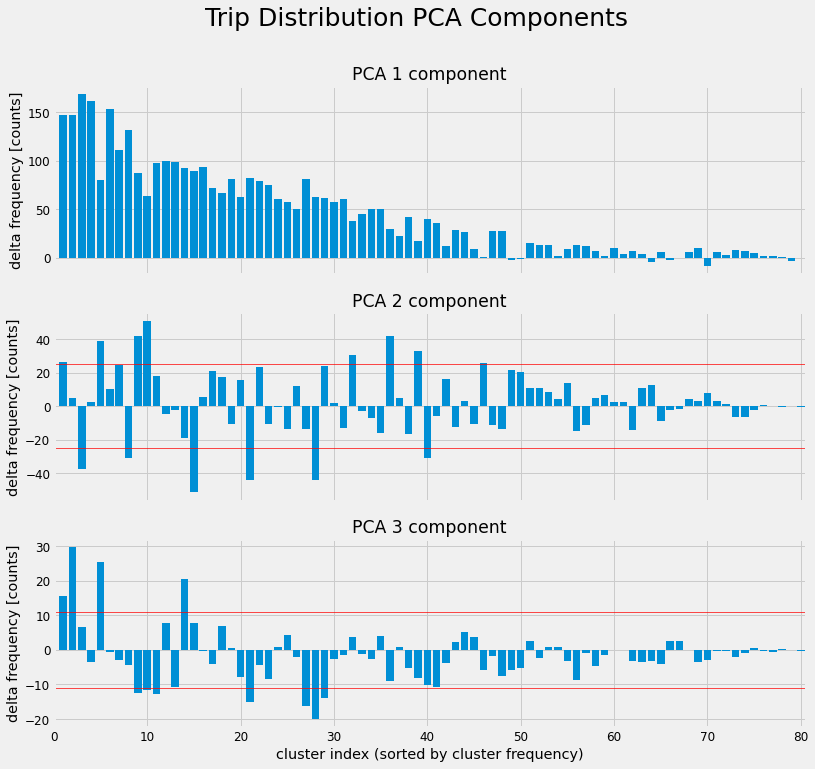

In [19]:
#%% examine what different PC coefficients mean by looking at their trip template distributions
fig, axArray = plt.subplots(nrows=numComponents,ncols=1,sharex=True, figsize=(12,11))
fig.suptitle('Trip Distribution PCA Components', fontsize=25)
for PC_coeff in range(numComponents):
    tripTemplateDistributionDifference = TripDistributionPCAModel.components_[PC_coeff,:] * \
                                         TripDistributionPCAModel.explained_variance_[PC_coeff]
    axArray[PC_coeff].bar(range(1,numClusters+1),tripTemplateDistributionDifference)
    axArray[PC_coeff].set_title('PCA %d component' %(PC_coeff+1))
    axArray[PC_coeff].set_ylabel('delta frequency [counts]')
    
axArray[PC_coeff].set_xlabel('cluster index (sorted by cluster frequency)')
axArray[PC_coeff].set_xlim(0,numClusters+0.5)

axArray[1].hlines([-25,25], 0, numClusters+0.5, colors='r', lw=0.7)
axArray[2].hlines([-11,11], 0, numClusters+0.5, colors='r', lw=0.7)

最初のPCAコンポーネントは全体的なトリップ分布に非常によく似ていることがわかります。これは、その期間の総トリップ数のみを制御する主に「ゲイン」コンポーネントであることを示唆しています。

2番目と3番目のコンポーネントには、上下に異なるパターンがあります。

それらのパターンが何であるか、特に赤い線から逸脱するすべてのものを調べてみましょう

##### PC 2 large deviating trips
赤の矢印は、PC 2係数が増加するときに増加するトリップを示します。

青色の矢印は、PC 2係数が増加するときに減少するトリップを示します。

マゼンタの円はソースで、緑の円は宛先です。

Text(0.5, 1.0, 'PC2 major Trip deviations')

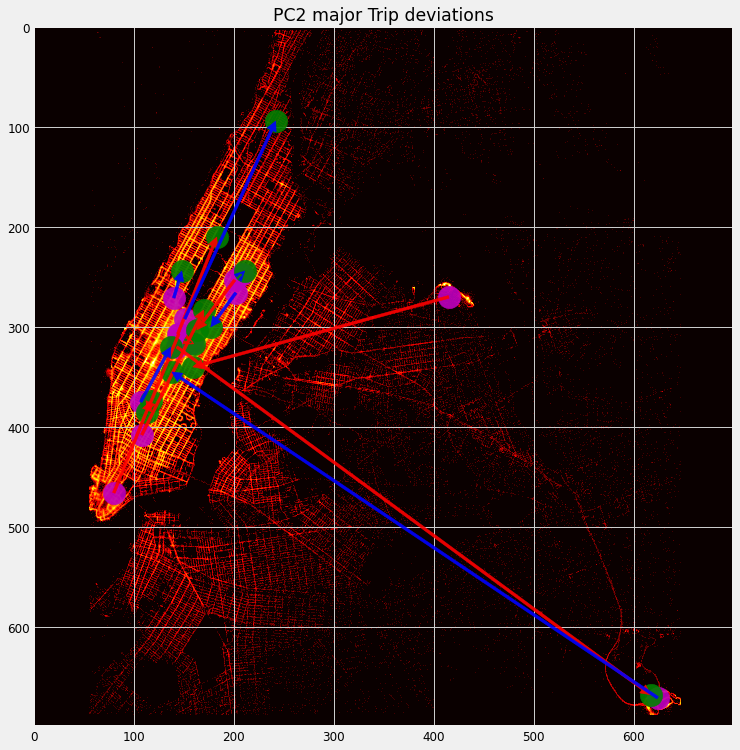

In [20]:
#%% put the large deviating trips of each component back on the map
numTopTripsToShow = 8
numBottomTripsToShow = 6

# meaning of 2nd PC
sortedTripClusters_PC2 = np.argsort(TripDistributionPCAModel.components_[1,:])
topPositiveTripClusterInds = sortedTripClusters_PC2[-numTopTripsToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC2[:numBottomTripsToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC2 major Trip deviations')

赤の矢印は、PC係数が増加すると増加するトリップを示します。
青色の矢印は、PC係数が増加すると減少するトリップを示します。
マゼンタの円はソースで、緑の円は宛先です。

以前、PC2は夜間の活動が増加することを確認しました。 実際、私たちが目にするほとんどの旅行は、マンハッテン内の短い旅行です。おそらく人々は皆、暑い場所に行くでしょう。

##### PC 3 large deviating trips

Text(0.5, 1.0, 'PC3 major Trip deviations')

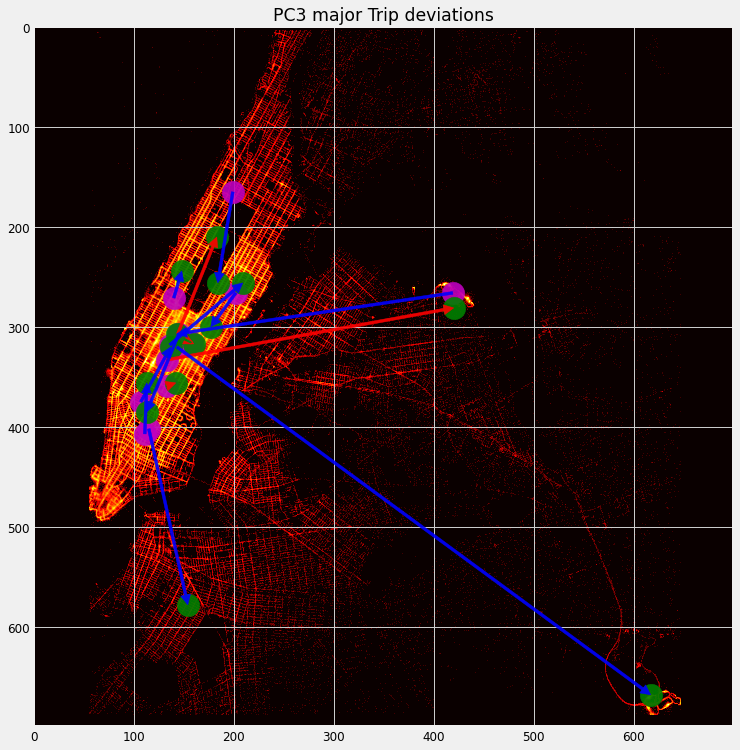

In [21]:
# meaning of 3rd PC
numTopTripsToShow = 4
numBottomTripsToShow = 10

sortedTripClusters_PC3 = np.argsort(TripDistributionPCAModel.components_[2,:])
topPositiveTripClusterInds = sortedTripClusters_PC3[-numTopTripsToShow:]
topNegativeTripClusterInds = sortedTripClusters_PC3[:numBottomTripsToShow]
allInds = np.hstack((topPositiveTripClusterInds,topNegativeTripClusterInds))

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1][allInds],srcImCoords[0][allInds],c='m',s=500,alpha=0.9)
plt.scatter(dstImCoords[1][allInds],dstImCoords[0][allInds],c='g',s=500,alpha=0.9)

for i in topPositiveTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='r', facecolor='r', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)

for i in topNegativeTripClusterInds:
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='b', facecolor='b', width=2.8,alpha=0.9,head_width=10.0,head_length=10.0,length_includes_head=True)
plt.title('PC3 major Trip deviations')

これは、これが早起きでどの旅行が行われるかを示す主要なコンポーネントであることを以前に確認しました。

以上が、ノートブックの内容。

### 課題
- 他のノートブックにも興味深い分析方法があったので、参照してみる。
- 上記の分析をもとに特徴量選択し、学習・予測してみる。
  - 特徴量として生カラム・PCA次元削減をしたものそれぞれの結果を比較
  - PCAの要素数を増やして分析してみる